# Universal sampling: better sampling for a better tomorrow

[Universal hashing](https://en.wikipedia.org/wiki/Universal_hashing) is a powerful primitive for statistical analysis at scale. Universal hash functions efficiently and deterministically map inputs to integers that are uniformly distributed within the binary range of an integer type (e.g., a 64-bit long).

Why would you want to do this? Deterministic sampling allows for complete reproducibility within and between instances of 1 to $\infty$. This allows for completely memoryless and stateless sampling from a dataset or draws from a distribution. 
* You can cluster sample in a single pass
* You can sample the same identities in a stream or between different batch runs
* You can efficiently bootstrap and apply computational statistics at scale
* You can build approximate representations of sets or datasets ("sketches")
* ...and a lot of other things I'm not thinking about right now but you'll eventually discover

The two universal families that I come across most often for data science, data engineering, and machine learning applications are [MurmurHash](https://github.com/aappleby/smhasher) and [xxHash](https://github.com/Cyan4973/xxHash):
* `scikit-learn` uses MurmurHash for [feature hashing via the hashing trick](https://scikit-learn.org/stable/modules/feature_extraction.html#feature-hashing)
* The Scala standard library includes a [MurmurHash implementation](https://www.scala-lang.org/api/2.12.x/scala/util/hashing/MurmurHash3$.html)
* Apache Spark includes functions for both [MurmurHash](https://spark.apache.org/docs/latest/api/sql/index.html#hash) and [xxHash](https://spark.apache.org/docs/latest/api/sql/index.html#xxhash64). Spark has long used MurmurHash for [hash partitioning](https://jaceklaskowski.gitbooks.io/mastering-spark-sql/content/spark-sql-HashPartitioning.html) to efficiently and uniformly distributed data for computation.

Universal hashing is by no means limited to these families; MurmurHash and xxHash are particularly relevant to DS/DE/ML work because they are very fast and do not try to meet cryptographic requirements. And there are other hash families in this vein. For example, Snowflake includes an unspecified [64-bit uniform hash function](https://docs.snowflake.com/en/sql-reference/functions/hash.html).

In [1]:
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
from scipy import stats
from sklearn.utils.murmurhash import murmurhash3_32
from typing import Union
from uuid import uuid4

random_state = np.random.RandomState(12345)
spark = SparkSession.builder.getOrCreate()

%matplotlib inline

In [2]:
INT_MIN = np.int32(-(2**31))
INT_MAX = np.int32(2**31 - 1)
INT_RANGE = np.int64(2**32)

_mmhash_ufunc = np.frompyfunc(murmurhash3_32, nin=1, nout=1)


def mmhash(values):
    """Wrapper for sklearn's MurmurHash that accepts most types"""
    if np.ndim(values):
        if np.issubdtype(values.dtype, np.int32):
            return murmurhash3_32(values)
        return _mmhash_ufunc(values.astype(np.bytes_)).astype(
            np.int32
        )
    if isinstance(values, (bytes, str, np.int32)):
        return murmurhash3_32(values)
    return _mmhash_ufunc(np.array(values, dtype=np.bytes_))

## Hashing

Let's take a look at universal hashing in Python with `scikit-learn`'s MurmurHash implementation. For exmaple inputs, I create integer range and random normal arrays and hash their values. Despite the differences in the input distributions, each value in each array is unique so the hash values of both are approximately uniformly distributed in the 32-bit signed range $\left[ -2^{31}, 2^{31} \right)$. 

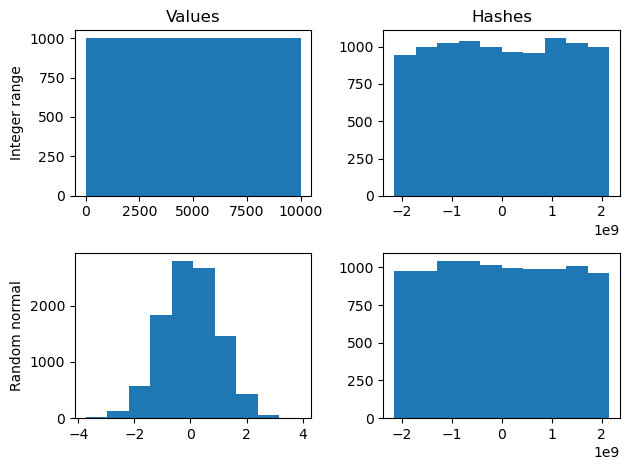

In [3]:
n = 10**4

integers = np.arange(n, dtype=np.int32)
normals = random_state.normal(size=n)

assert len(set(integers)) == n
assert len(set(normals)) == n

integer_hashes = mmhash(integers)
normal_hashes = mmhash(normals)

assert len(set(integer_hashes)) == n
assert len(set(normal_hashes)) == n
assert all(integer_hashes != normal_hashes)

fig, ax = plt.subplots(ncols=2, nrows=2)

for i, x in enumerate(
    [integers, integer_hashes, normals, normal_hashes]
):
    ax[i // 2, i % 2].hist(x)

ax[0, 0].set_title("Values")
ax[0, 1].set_title("Hashes")
ax[0, 0].set_ylabel("Integer range")
ax[1, 0].set_ylabel("Random normal")

fig.tight_layout();

These hashes are uniformly distributed in this range because each bit is randomly activated.

In [4]:
bytes_righty = (
    integer_hashes.astype("uint32").view("uint8").reshape(-1, 4)
)

# double check that i have the ops right
assert all(
    integer_hashes.astype("uint32")
    == np.bitwise_or.reduce(
        np.left_shift(bytes_righty, np.arange(4) * 8).T
    )
)

bytes_lefty = bytes_righty[:, ::-1]
bits = np.unpackbits(bytes_lefty).reshape(-1, 32)

In [5]:
bits.mean()

0.500484375

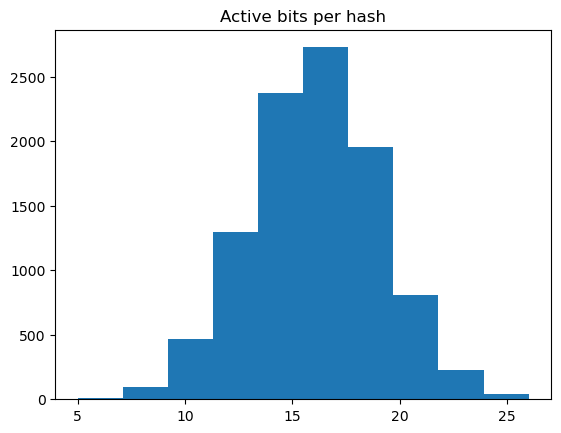

In [6]:
fig, ax = plt.subplots()
ax.hist(bits.sum(axis=1))
ax.set_title("Active bits per hash");

If you're in an environment without these fast non-cryptographic hash functions, remember that cryptographic functions provide you many random bytes. For example, we can take the last 4 bytes of MD5 hashes (8 hex characters).

In [7]:
md5_randint = np.array(
    [
        int(hashlib.md5(bytes(value)).hexdigest()[-8:], 16)
        for value in integers
    ],
    dtype=np.uint32,
).astype(np.int32)

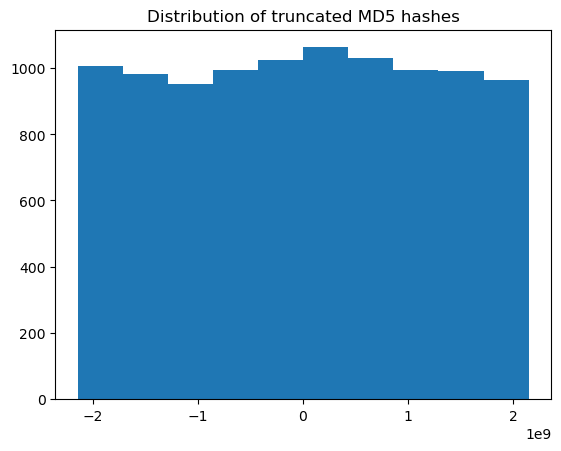

In [8]:
fig, ax = plt.subplots()
ax.hist(md5_randint)
ax.set_title("Distribution of truncated MD5 hashes");

## Random sampling

<div class="alert alert-block alert-info" > I'm going to compare the <code>pandas</code> sampling interface with universal sampling. The <code>pandas</code> interface is generally representative of the tools I'm familiar with (PySpark, R base/<code>dplyr</code>, SQL, etc.). It would not surprise me to learn that there are richer implementations around that don't have some of the downsides I'll point out below. </div> 


The simplest application of universal hashing is random sampling. We start with a representative dataframe of users, individual activity, and scores.

In [9]:
users = 10**4
avg_posts_per_user = 5

df = pd.DataFrame(
    [
        (user_id, activity_id, score)
        for user_id, posts in zip(
            random_state.randint(10**6, 10**7, users),
            random_state.poisson(avg_posts_per_user, users),
        )
        for activity_id, score in enumerate(
            random_state.normal(0, 1, posts)
        )
    ],
    columns=["user_id", "activity_sequence", "score"],
)

Dataframes in various packages or platforms usually make _simple_ random sampling very easy. 

In [10]:
sample_rate = 0.15
df.sample(frac=sample_rate).head()

,user_id,activity_sequence,score
26877,1294096,3,-0.121722
5793,9561491,1,-0.132633
18607,3302639,0,2.134427
11186,4726394,0,1.013974
16286,5668122,3,-1.567267


Reproducibility is controlled through seeds for random numbers. Given identical inputs, this method provides reproducible sample by row.

In [11]:
sample0 = df.sample(frac=sample_rate, random_state=2323)
sample1 = df.sample(frac=sample_rate, random_state=2323)
sample0.equals(sample1)

True

More general forms of random sampling are usually incovenient. For example, sampling half of our users requires deduplicating the users and sampling from that set, then filtering the original data.

In [12]:
(
    df[["user_id"]]
    .drop_duplicates()
    .sample(frac=sample_rate)
    .merge(df)
    .head()
)

,user_id,activity_sequence,score
0,3594621,0,0.318478
1,3594621,1,-1.685237
2,3594621,2,-0.479954
3,3594621,3,0.502334
4,3594621,4,-0.817127


And there is no answer to sampling from non-identical inputs: these dataframe methods are based on random numbers drawn independently of the data.

In [13]:
sample0 = df.sample(frac=sample_rate, random_state=2323)
sample1 = df.iloc[::-1].sample(
    frac=sample_rate, random_state=2323
)
sample0.equals(sample1.iloc[::-1])

False

In [14]:
users = df[["user_id"]].drop_duplicates(ignore_index=True)
sample0 = users.iloc[:1000].sample(
    frac=sample_rate, random_state=2323
)
sample1 = users.iloc[500:1500].sample(
    frac=sample_rate, random_state=2323
)

l = sample0.merge(users.iloc[500:1000])
r = sample1.merge(users.iloc[500:1000])
l.merge(r, how="outer", indicator=True).groupby("_merge").count()

,user_id
_merge,
left_only,69
right_only,67
both,7


The kinds of problems can be addressed with universal sampling. For a hash function $f_{[a,b)}$ producing hash values $h_i \in \left[a, b \right)$ and sample rate $r$, we transform the rate to a ceiling value such that we keep $h_i < \left( a + r * (b - a) \right)$.

We can still do independent sampling based on a value that's unique to a row (here just the row number).

In [15]:
sample_ceiling = INT_MIN + int(sample_rate * INT_RANGE)
df[df.index.map(mmhash) < sample_ceiling].head()

,user_id,activity_sequence,score
1,4458669,1,-0.108092
10,4521687,5,-0.744671
11,4521687,6,-0.644479
14,9627518,2,0.377447
24,7517891,0,-0.723131


Sampling all data for a subset of users is as simple as changing the input to the hash function.

In [16]:
df[mmhash(df["user_id"]) < sample_ceiling].head()

,user_id,activity_sequence,score
27,2371857,0,1.699181
28,2371857,1,0.018043
29,2371857,2,0.552085
30,2371857,3,0.775177
31,2371857,4,-1.122306


The properties of universal hash functions allow us to sample from non-identical data, such as a stream or distributed dataset. For example, we can sample the same users from differing subsets.

In [17]:
users = df[["user_id"]].drop_duplicates(ignore_index=True)
batch0 = users.iloc[:1000]
batch1 = users.iloc[500:1500]
overlap = users.iloc[500:1000]

l = batch0[mmhash(batch0["user_id"]) < sample_ceiling]
r = batch1[mmhash(batch1["user_id"]) < sample_ceiling]
l.merge(r, how="outer", indicator=True).merge(overlap).groupby(
    "_merge"
).count()

,user_id
_merge,
left_only,0
right_only,0
both,59


### Multiple hash functions

A single hash function deterministically maps an input. Sometimes we want a different hash function. For example, we don't want to sample the same set of users for every analysis. This is particularly relevant for universal sampling from distributions because pseudo-random number generation algorithms often require multiple seed inputs.

The easiest way to change a hash function is to salt the input. For example, any operation that produces a new, unique value not equal to the input will yield a new, uncorrelated hash. Such an operation includes the hash function itself.

In [18]:
np.corrcoef(mmhash(integers), mmhash(integers + 1))[0, 1]

0.01906422861062026

In [19]:
np.corrcoef(mmhash(integers), mmhash(mmhash(integers)))[0, 1]

-0.006641027550636124

For hash functions that accept multiple inputs, the salt can just be another argument. This is an equivalent strategy to the above: we're essentially converting the original input to bytes (if it wasn't already) and appending salting bytes.

In [20]:
import pyspark.sql.functions as F

F.hash(F.col("column"), F.lit("salt"))

Column<'hash(column, salt)'>

Repeated hashing is computationally expensive, can be error-prone (using an incorrect salting method), and can introduce serialized computation. This can outweigh its benefits (simplicity and strong guarantees) with large datasets or many hash functions. In practice, we can produce new pseudorandom numbers by integer multiplication with random numbers from the same discrete uniform distribution.

In [21]:
def randomize_hashes(hashes, k, random_seed):
    """Randomize hash values k times"""
    hashes = hashes.astype(np.int32)
    random_state = np.random.RandomState(random_seed)
    random_integers = random_state.randint(
        INT_MIN, INT_MAX, k, np.int32
    )
    return np.multiply.outer(hashes, random_integers)


np.corrcoef(
    np.vstack(
        [
            integer_hashes,
            randomize_hashes(
                integer_hashes, k=5, random_seed=858623
            ).T,
        ]
    )
)[0, 1:]

array([ 0.0010438 ,  0.0122731 ,  0.00666873, -0.00060876,  0.01207721])

### Universal sampling from the uniform distribution

Suppose we want a value from a uniform distribution. Well, the universal hash functions describe above produce such a pseudo-random value.

Mapping the hash value to arbitrary discrete and continuous uniform distributions is trivial:
* A hash value $h$ can be mapped to an arbitrary discrete uniform $U \lbrace a, b \rbrace$ by $ \left[ h \mod (b - a) \right] + a $, where $\text{mod}$ is the positive modulo operator
* A hash function $f$ with bits $b$ produces a hash value $h$ that can be mapped to an arbitrary continuous uniform $U \left[a, b \right]$ by $ \left( \dfrac{h}{2^b} + \begin{cases} .5 & \text{if}\ f\ \text{is signed} \\ 0  & \text{if}\ f\ \text{is unsigned} \end{cases} \right) \cdot (b - a) + a $

### Universal sampling from the normal distribution

[There are several ways to generate values from the normal distribution that leverage samples from the uniform distribution](https://en.wikipedia.org/wiki/Normal_distribution#Generating_values_from_normal_distribution). According to the [Irwin-Hall distribution](https://en.wikipedia.org/wiki/Irwin%E2%80%93Hall_distribution#Approximating_a_Normal_distribution), the scaled, centered sum of 12 random uniform values is approximately normally distributed. This is trivial to implement and is accurate enough for most applied work.

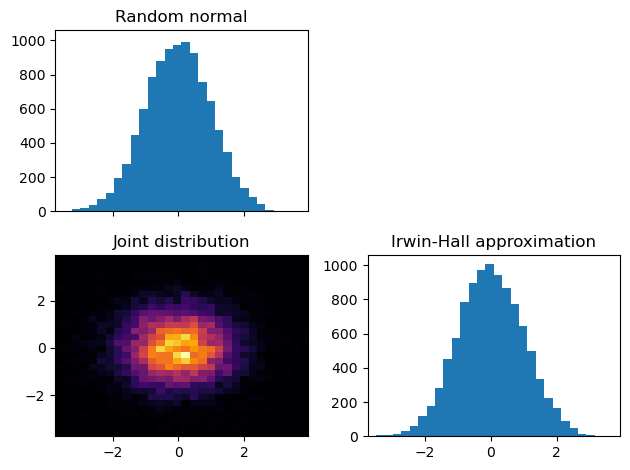

In [22]:
n = 10**6

# distinct hashes for those distinct values
hashes = mmhash(normals)

# approximate a normal from the hashes
irwin_hall_approx = (
    randomize_hashes(hashes, k=12, random_seed=73529) / INT_RANGE
).sum(axis=1)


# visualize

fig, ax = plt.subplots(2, 2, sharex=True)

bins = np.histogram_bin_edges(
    np.r_[normals, irwin_hall_approx], bins=30
)

ax[0, 0].set_title("Random normal")
ax[0, 0].hist(normals, bins=bins)

ax[1, 1].set_title("Irwin-Hall approximation")
ax[1, 1].hist(irwin_hall_approx, bins=bins)

ax[0, 0].sharex(ax[1, 0])
ax[0, 0].sharey(ax[1, 1])

ax[1, 0].set_title("Joint distribution")
ax[1, 0].hist2d(
    normals, irwin_hall_approx, bins=bins, cmap="inferno"
)

fig.delaxes(ax[0, 1])
plt.tight_layout();

As long as an evaluation uses the same random integers for permutation, this opens the benefits of universal hashing to random normal sampling: completely independent and deterministic sampling for every distinct input to the hash function.

More exact samples can be generated by converting the hashes to continuous uniform samples (discussed above), including the non-iterative [Box-Muller transform](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform).

More approximate samples can be generated with inverse transform sampling, which we used below for Poisson sampling.

### Universal sampling from the Poisson distribution

The Poisson distribution is well-suited for [inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) when [the value of $\lambda$ (the mean of the distribution) is relatively small](https://en.wikipedia.org/wiki/Poisson_distribution#Random_variate_generation). Given the most common uses of the random the Poisson use such small $\lambda$ values, inverse transformation can be our default method for Poisson universal sampling.

The inverse transform method simply relates values of the cumulative distribution function to values of the distribution. In discrete cases, starting at zero this can be simplified to a single array where the index represents the value from the distribution. 

For index-based inverse transforms, we can simply evaluate inverse CDF within our tolerated range. For our small values of $\lambda$, in the Poisson distribution, the lower bound of this range will be zero. Index edges are inversely mapping the CDF values along this range to the range of our hash values.

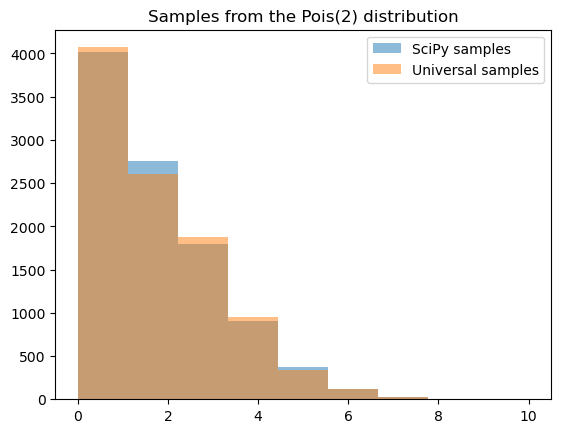

In [23]:
def poisson_sampling(hashes, lam, tol=1e-12):
    pois = stats.poisson(lam)
    lower, upper = np.ceil(pois.isf([1 - tol, tol]))

    edges = (
        pois.cdf(np.arange(lower, upper)) * INT_RANGE + INT_MIN
    ).astype(np.int32)

    poisson = pois.rvs(
        size=len(hashes), random_state=random_state
    )
    univseral_poisson = (
        np.searchsorted(edges, hashes, side="right") + lower
    )

    fig, ax = plt.subplots()
    num_bins = int(
        min(max(poisson.max(), univseral_poisson.max()) - 1, 30)
    )
    _, bins, _ = ax.hist(
        poisson, bins=num_bins, label="SciPy samples", alpha=0.5
    )
    ax.hist(
        univseral_poisson,
        bins=bins,
        label="Universal samples",
        alpha=0.5,
    )
    ax.set_title(f"Samples from the Pois({lam}) distribution")
    ax.legend()


poisson_sampling(integer_hashes, 2)

This method is still perfectly valid with values of $\lambda$ much larger than typically used, but it may be computationally inefficient.

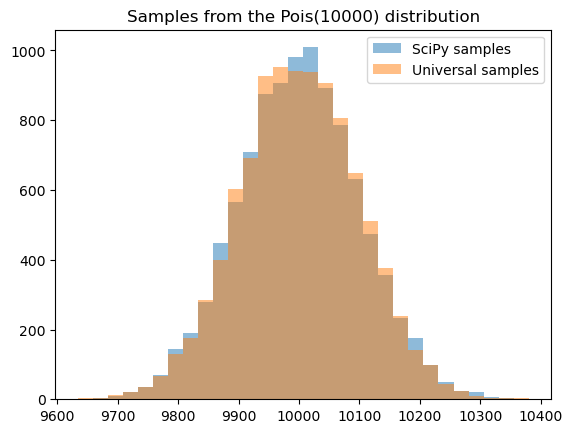

In [24]:
poisson_sampling(integer_hashes, 10000)

## Universal sampling from arbitrary distributions via approximate inverse transformation

Every distribution will have a best method for generating random values from universal hash seeds. In practice, these won't always be tractable or even possible (e.g., infrastructure constraints).

Inverse transformation provides a general method of approximation in these cases. The approach is simple:
1. Evenly divide the (0, 1) interval 
2. Calculate the quantile at each value in the interval
3. Integerize the interval to the hash range 
4. Use the insertion position of hash values into the interval array to choose the quantile, breaking ties by choosing the quantile closest to the median
5. If continuous, use a second hash function to interpolate within the quantile

The precision of the approximation is controlled by the size of the lookup table we're willing to create. 

In [25]:
stats.rv_continuous

scipy.stats._distn_infrastructure.rv_continuous

In [26]:
def inverse_approximation(
    hashes,
    distribution,
    tol=1e-12,
    table_size=1000,
    randomize=-860787389,
):
    # cdf is full linear space in the tolerance range
    cdf = np.linspace(tol, 1 - tol, table_size)

    # values are evaluated at the CDF and padded with inf
    values = np.r_[-np.inf, distribution.isf(cdf[::-1]), np.inf]

    # edges are the integerized cdf
    # padded with the extrema to match size of values
    unpadded = (cdf * INT_RANGE + INT_MIN).astype(np.int32)
    edges = np.r_[INT_MIN, unpadded, INT_MAX]

    # get index in edges for the hashes
    # choose the side closer to the center
    index = np.where(
        hashes < 0,
        np.searchsorted(edges, hashes, side="right"),
        np.searchsorted(edges, hashes),
    )

    samples = distribution.rvs(
        size=len(hashes), random_state=random_state
    )
    inverse_samples = values[index]
    if isinstance(distribution, stats.rv_continuous):
        between_values = values[
            np.where(hashes < 0, index + 1, index - 1)
        ]
        min_ = np.minimum(inverse_samples, between_values)
        max_ = np.maximum(inverse_samples, between_values)
        interp = hashes * randomize / INT_RANGE + 0.5
        inverse_samples += (max_ - min_) * interp

    fig, ax = plt.subplots()
    num_bins = 30
    if isinstance(distribution, stats.rv_discrete):
        _ = np.r_[samples, inverse_samples]
        sample_range = _.max() - _.min()
        num_bins = min(30, sample_range)

    _, bins, _ = ax.hist(
        samples, bins=num_bins, label="SciPy samples", alpha=0.5
    )
    ax.hist(
        inverse_samples,
        bins=bins,
        label="Universal samples",
        alpha=0.5,
    )
    ax.legend()
    return ax

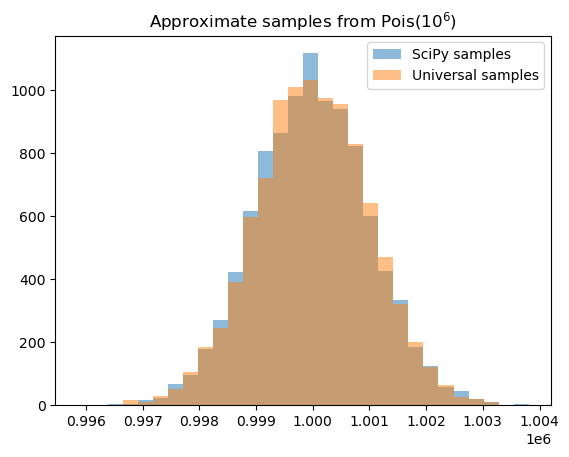

In [27]:
ax = inverse_approximation(
    integer_hashes, stats.poisson(10**6)
)
ax.set_title("Approximate samples from Pois($10^6$)");

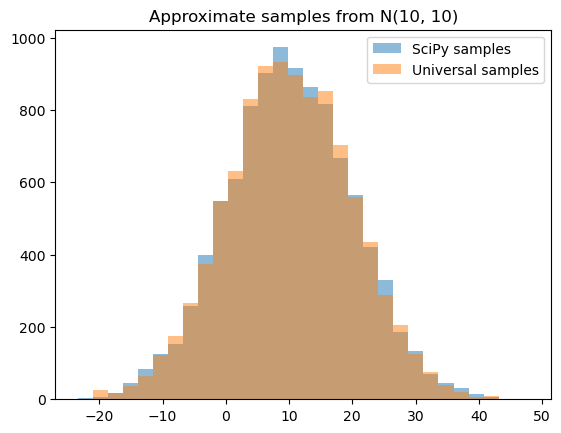

In [28]:
ax = inverse_approximation(integer_hashes, stats.norm(10, 10))
ax.set_title("Approximate samples from N(10, 10)");

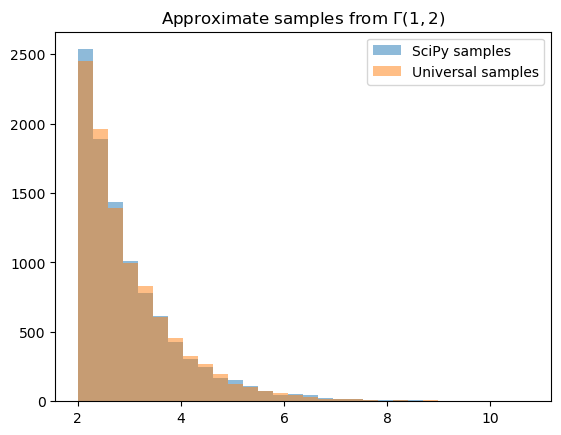

In [29]:
ax = inverse_approximation(integer_hashes, stats.gamma(1, 2))
ax.set_title("Approximate samples from $\Gamma(1, 2)$");

### Wrapping up

The immediate applications of universal sampling from data are evident. It may be less clear why you might care about universal sampling from distributions. If you noticed that I didn't cover sampling with replacement, there is at least one very important application of sampling from distributions that I'll cover in my next post: Poisson resampling and bootstrap.